## Tabla de Contenidos

1. <a href='#section_Importacion_de_modules'>Importación de modules</a>
2. <a href='#section_Importacion_de_dataset'>Importación del dataset patient_covid.csv</a>
3. <a href='#section_Modelos'>Modelos</a> 
</br>3.1 <a href='#section_KNN'>KNN</a>
</br>3.2 <a href='#section_rl'>Regresión logística</a>
</br>3.3 <a href='#section_nbm'>Naive Bayes multinomial</a>
4. <a href='#section_1'>otro1</a> 

------------
</br>3.1.1. <a href='#section_preparacion'>Preparar la matriz de _features_ y el vector _target_</a>
</br>3.1.1. <a href='#section_optimizando'>Optimizando el valor de _k_</a>
</br>3.1.2. <a href="#section_confusion">Matriz de confusión</a>
</br>3.1.3. <a href="#section_conclusion">Conclusión</a>


# **1. Importación de *modules***
<a id="section_Importacion_de_modules"></a>

In [23]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn import metrics
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score ,f1_score ,classification_report , confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize, StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings("ignore")

import funciones as f


!pip install graphviz
!pip install pydotplus

from IPython.display import Image
import pydotplus

# **2. Importación del dataset patient_covid.csv**
<a id="section_Importacion_de_dataset"></a>

In [24]:
data_covid = pd.read_csv("../data/patient_covid.csv", sep = ",", low_memory=False) 
f._get_info(data_covid)
f._summary(data_covid)
#data_covid_knn = pd.read_csv("../data/patient_covid_knn.csv", sep = ",", low_memory=False) 
#data_covid_knn = pd.read_csv("../data/patient_covid.csv", sep = ",", low_memory=False) 

(95244, 28)


,inpatient,agegroup_10-19,agegroup_20-29,agegroup_30-39,agegroup_40-49,agegroup_50-59,agegroup_60-69,agegroup_70-79,agegroup_80-89,agegroup_90-99,...,diabetes_Y,hypertension_Y,immunosuppression_Y,obesity_Y,other_diseases_N,other_diseases_Y,pneumonia_Y,pregnant_Y,sex_M,smoker_Y
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,1,1,0,1,1,0,0,0,1,0


,notnull,dtype,unique
inpatient,95244,int64,"(i, n, p, a, t, i, e, n, t)"
agegroup_10-19,95244,int64,"(a, g, e, g, r, o, u, p, _, 1, 0, -, 1, 9)"
agegroup_20-29,95244,int64,"(a, g, e, g, r, o, u, p, _, 2, 0, -, 2, 9)"
agegroup_30-39,95244,int64,"(a, g, e, g, r, o, u, p, _, 3, 0, -, 3, 9)"
agegroup_40-49,95244,int64,"(a, g, e, g, r, o, u, p, _, 4, 0, -, 4, 9)"
agegroup_50-59,95244,int64,"(a, g, e, g, r, o, u, p, _, 5, 0, -, 5, 9)"
agegroup_60-69,95244,int64,"(a, g, e, g, r, o, u, p, _, 6, 0, -, 6, 9)"
agegroup_70-79,95244,int64,"(a, g, e, g, r, o, u, p, _, 7, 0, -, 7, 9)"
agegroup_80-89,95244,int64,"(a, g, e, g, r, o, u, p, _, 8, 0, -, 8, 9)"
agegroup_90-99,95244,int64,"(a, g, e, g, r, o, u, p, _, 9, 0, -, 9, 9)"


# **3.Modelos**
<a id="section_Modelos"></a>

#### ***Preparar la matriz de _features_ y el vector _target y Train-test_***
<a id="section_preparacion"></a>

In [25]:
data_covid['inpatient'].value_counts(normalize=True)

0    0.734629
1    0.265371
Name: inpatient, dtype: float64

In [26]:
cols_features=data_covid.columns.difference(['inpatient'])
X = data_covid[cols_features]
y = data_covid['inpatient']
f._get_info(X)

(95244, 27)


,agegroup_10-19,agegroup_20-29,agegroup_30-39,agegroup_40-49,agegroup_50-59,agegroup_60-69,agegroup_70-79,agegroup_80-89,agegroup_90-99,asthma_Y,...,diabetes_Y,hypertension_Y,immunosuppression_Y,obesity_Y,other_diseases_N,other_diseases_Y,pneumonia_Y,pregnant_Y,sex_M,smoker_Y
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,1,1,0,1,1,0,0,0,1,0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,stratify=data_covid['inpatient'],random_state=123)
display(y_train.value_counts(normalize=True).round(3))
display(y_test.value_counts(normalize=True).round(3))

print ("X_train:" , X_train.shape[0])
print ("y_train:" , y_train.shape[0])
print ("X_test:" , X_test.shape[0])
print ("y_test:" , y_test.shape[0])

0    0.735
1    0.265
Name: inpatient, dtype: float64

0    0.735
1    0.265
Name: inpatient, dtype: float64

X_train: 57146
y_train: 57146
X_test: 38098
y_test: 38098


## **3.2. Regresión logística** <a id="section_rl"></a>

In [28]:
#Logistic regression
#scaler = StandardScaler()
#x_trainstd = scaler.fit_transform(x_train)
#x_teststd = scaler.transform(x_test)
lr = LogisticRegression(class_weight="balance")
lr.fit(X_train, y_train)
score_lr= lr.score(X_test, y_test)

display("Logistic Regression Score:", score_lr)
y_pred_lr = lr.predict(X_test)

display("AS LR:\n", accuracy_score(y_test, y_pred_lr))
display("CM LR:\n", confusion_matrix(y_test, y_pred_lr))


display("LR intercept:\n", lr.intercept_)
display("LR Coef:\n", lr.coef_)



LogisticRegression(class_weight='balance')

'Logistic Regression Score:'

0.8724604966139955

'AS LR:\n'

0.8724604966139955

'CM LR:\n'

array([[26793,  1195],
       [ 3664,  6446]], dtype=int64)

'LR intercept:\n'

array([0.76281446])

'LR Coef:\n'

array([[-1.25239179, -1.93079362, -1.88258526, -1.51711745, -1.1315724 ,
        -0.71461601, -0.19883157,  0.15145117,  0.34323499, -0.10710172,
         0.09934592, -0.87982914,  0.24166746,  0.60274801,  0.40991728,
         0.62601843, -0.87360097, -0.25435077,  0.2297941 ,  0.90475071,
         0.19056778, -0.25805523,  0.22853881,  3.47424102,  1.78215009,
         0.32998243,  0.04147073]])

In [29]:
print("LR:\n", classification_report(y_test,y_pred_lr))

LR:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     27988
           1       0.84      0.64      0.73     10110

    accuracy                           0.87     38098
   macro avg       0.86      0.80      0.82     38098
weighted avg       0.87      0.87      0.87     38098



### Barplot Summary of Feature Importance

<BarContainer object of 27 artists>

Text(0.5, 1.0, 'Barplot Summary of Feature Importance')

Text(0.5, 0, 'score')

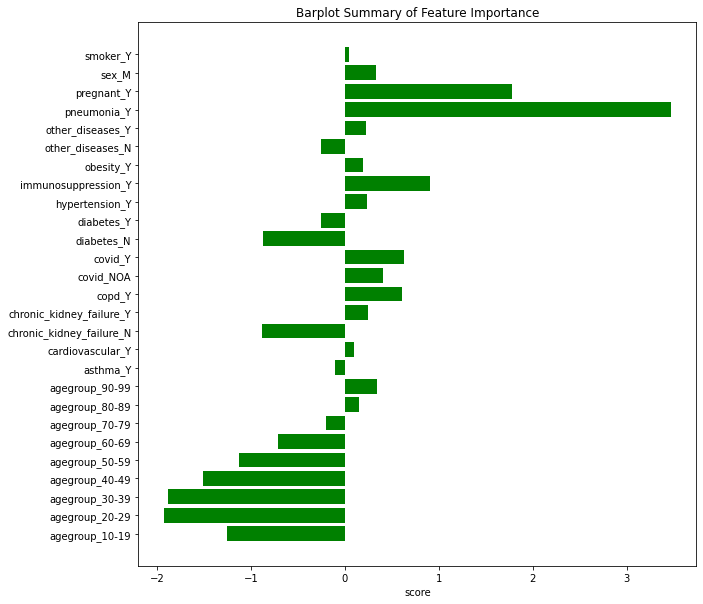

In [30]:
importance = lr.coef_.flatten()

plt.rcParams["figure.figsize"] =(10,10)
plt.barh(X.columns,importance,color="g")
plt.title("Barplot Summary of Feature Importance")
plt.xlabel("score")
plt.show()

### ROC

In [31]:
#LR
probs_lr=lr.predict_proba(X_test)
preds_lr=probs_lr[:,1]
fpr_lr,tpr_lr, threshold_lr =metrics.roc_curve(y_test, y_pred_lr)
roc_auc_lr=metrics.auc(fpr_lr,tpr_lr)

Text(0.5, 1.0, 'ROC')

(0.0, 1.0)

(0.0, 1.0)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

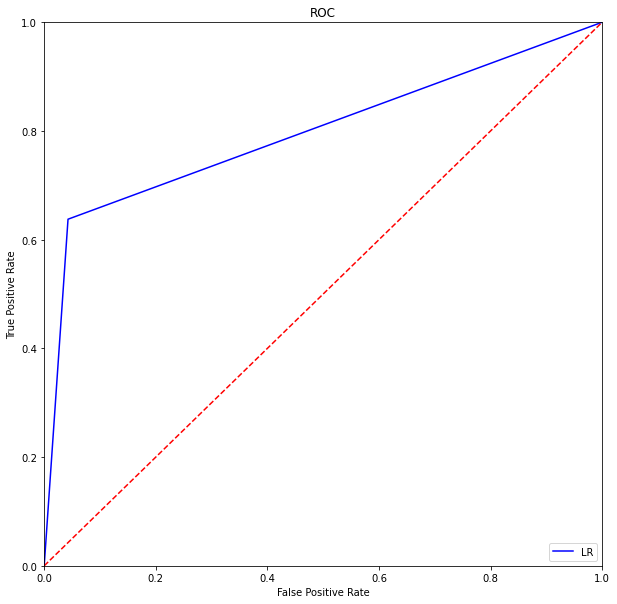

In [32]:
plt.title("ROC")

plt.plot(fpr_lr, tpr_lr, 'b', label="LR" % roc_auc_lr)

plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#  **5. Machine Learning Algorithms Target Patient Type <a id="section_1"></a>**

## **5.1 Modelos con parámetros por defecto***

### 5.1.1 Scoring Modelos con parámetros por defecto

In [33]:
#   .score is a shortcut to run .predict and then calculate the accuracy. So you should only hand it X_test and y_test. –

#Naive Bayes      
nb=MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
score_nb = accuracy_score(y_test,y_pred_nb).round(4)

#Tree Classification
clftree = tree.DecisionTreeClassifier(random_state=40)
clftree.fit(X_train, y_train)
y_pred_t = clftree.predict(X_test)
score_t = accuracy_score(y_test, y_pred_t).round(4)


# ##   standtizacion  ################################################
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
#X_test_std = scaler.transform(X_test)

#KNN (poner en n_neighbors el best_params_ de GridSearch)
#knn = KNeighborsClassifier()
knn = KNeighborsClassifier(n_neighbors=18)
#knn.fit(X_train_std, y_train)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
score_knn=accuracy_score(y_test, y_pred_knn).round(4)

#Logistic regression  !!!! revisar !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_std, y_train)
y_pred_lr = lr.predict(X_test)
score_lr=accuracy_score(y_test, y_pred_lr).round(4)

# ###  Score ###########################################################
print ("Naive Bayes Acc Score:    \t",score_nb)
print ("KNN Acc Score:\t\t\t",score_knn)
print ("Logistic Regression Acc Score:  ", score_lr)
print("Tree classification Acc Score:  ", score_t)

MultinomialNB()

DecisionTreeClassifier(random_state=40)

KNeighborsClassifier(n_neighbors=18)

LogisticRegression()

Naive Bayes Acc Score:    	 0.8473
KNN Acc Score:			 0.8697
Logistic Regression Acc Score:   0.7381
Tree classification Acc Score:   0.8647


### 5.1.2 Confusion_matrix Modelos con parámetros por defecto

<img src="http://acnalert.eastus.cloudapp.azure.com/2/ds/Confusion.jpg" alt="Matriz confusion">

In [34]:
print ("X_test:" , X_test.shape[0])
print ("y_test:" , y_test.shape[0])
print("CM NB:\n", confusion_matrix(y_test, y_pred_nb))
print("CM KNN:\n",confusion_matrix(y_test, y_pred_knn))
print("CM LR:\n", confusion_matrix(y_test, y_pred_lr))
print("T LR:\n",  confusion_matrix(y_test, y_pred_t))

X_test: 38098
y_test: 38098
CM NB:
 [[25575  2413]
 [ 3404  6706]]
CM KNN:
 [[26757  1231]
 [ 3733  6377]]
CM LR:
 [[27980     8]
 [ 9968   142]]
T LR:
 [[26511  1477]
 [ 3676  6434]]


[[25575  2413]
 [ 3404  6706]]


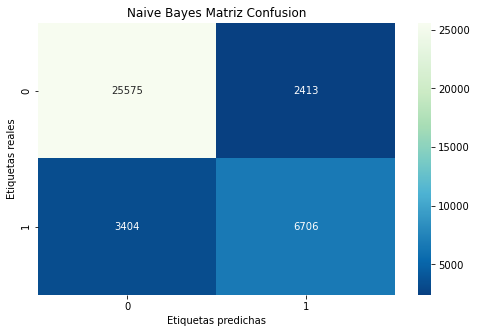

In [35]:
f._print_matriz_confusion(y_test, y_pred_nb,"Naive Bayes Matriz Confusion")

[[26757  1231]
 [ 3733  6377]]


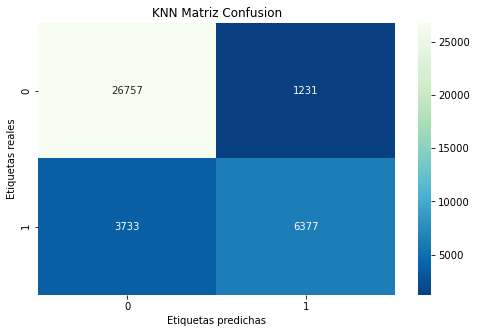

In [36]:
f._print_matriz_confusion(y_test, y_pred_knn,"KNN Matriz Confusion")

[[27980     8]
 [ 9968   142]]


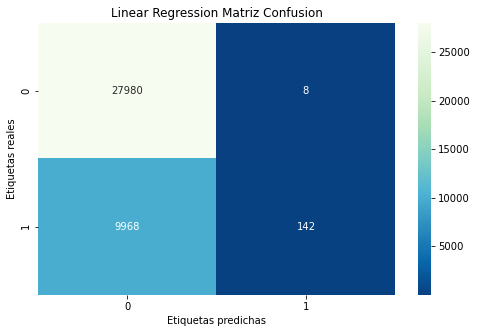

In [37]:
f._print_matriz_confusion(y_test, y_pred_lr,"Linear Regression Matriz Confusion")

[[26511  1477]
 [ 3676  6434]]


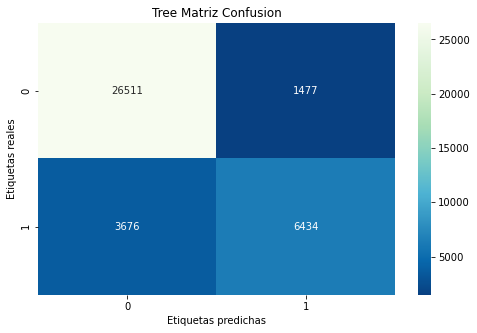

In [38]:
f._print_matriz_confusion(y_test, y_pred_t,"Tree Matriz Confusion")

### 5.1.3 Recall,Precision and F-1 Score Modelos con parámetros por defecto

* Recall    =  TP / (TP + FN)
* Precision = TP / (TP + FP) 
* F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [39]:
print("NB:\n", classification_report(y_test,y_pred_nb))
print("KNN:\n", classification_report(y_test,y_pred_knn))
print("LR:\n", classification_report(y_test,y_pred_lr))
print("T:\n", classification_report(y_test,y_pred_t))

NB:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90     27988
           1       0.74      0.66      0.70     10110

    accuracy                           0.85     38098
   macro avg       0.81      0.79      0.80     38098
weighted avg       0.84      0.85      0.84     38098

KNN:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     27988
           1       0.84      0.63      0.72     10110

    accuracy                           0.87     38098
   macro avg       0.86      0.79      0.82     38098
weighted avg       0.87      0.87      0.86     38098

LR:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85     27988
           1       0.95      0.01      0.03     10110

    accuracy                           0.74     38098
   macro avg       0.84      0.51      0.44     38098
weighted avg       0.79      0.74      0.63     38098

T:


In [40]:
print ("F1 Score NB: ", f1_score(y_test,y_pred_nb).round(4))
print ("F1 Score KNN:", f1_score(y_test,y_pred_knn).round(4))
print ("F1 Score LR: ", f1_score(y_test,y_pred_lr).round(4))
print ("F1 Score T:  ", f1_score(y_test,y_pred_t).round(4))

F1 Score NB:  0.6975
F1 Score KNN: 0.7198
F1 Score LR:  0.0277
F1 Score T:   0.7141


### 5.1.4 roc & auc Modelos con parámetros por defecto

In [41]:
def _metric_AUC(X_t,y_t,y_pred,modelo):  # return roc_auc,fpr,tpr,threshold
    probs=modelo.predict_proba(X_t)
    preds=probs[:,1]
    fpr,tpr,threshold=metrics.roc_curve(y_test, y_pred)
    roc_auc=metrics.auc(fpr,tpr)
    return roc_auc,fpr,tpr,threshold

# return roc_auc,fpr,tpr,threshold
#NB
roc_auc_nb,fpr_nb,tpr_nb,threshold_nb=_metric_AUC(X_test,y_test,y_pred_nb,nb)
#KNN
roc_auc_knn,fpr_knn,tpr_knn,threshold_knn=_metric_AUC(X_test,y_test,y_pred_knn,knn)
#LR
roc_auc_lr,fpr_lr,tpr_lr,threshold_lr=_metric_AUC(X_test,y_test,y_pred_lr,lr)
#T
roc_auc_t,fpr_t,tpr_t,threshold_t=_metric_AUC(X_test,y_test,y_pred_t,clftree)
print ("ROC AUC NB:  ",  roc_auc_nb.round(4))
print ("ROC AUC KNN: ", roc_auc_knn.round(4))
print ("ROC AUC LR:  ",  roc_auc_lr.round(4))
print ("ROC AUC T:   ",   roc_auc_t.round(4))



ROC AUC NB:   0.7885
ROC AUC KNN:  0.7934
ROC AUC LR:   0.5069
ROC AUC T:    0.7918


Text(0.5, 1.0, 'ROC')

(0.0, 1.0)

(0.0, 1.0)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

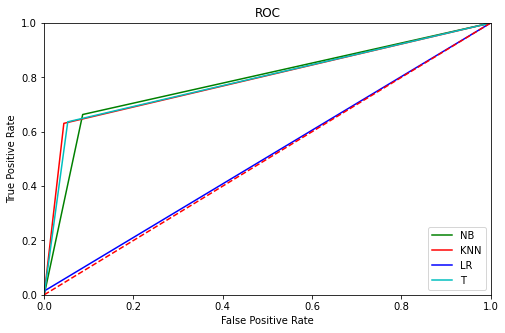

In [42]:
plt.title("ROC")
plt.rcParams['figure.figsize'] = (15, 6)
# return roc_auc,fpr,tpr,threshold
plt.plot(fpr_nb, tpr_nb, 'g', label="NB" )
plt.plot(fpr_knn, tpr_knn, 'r', label="KNN" )
plt.plot(fpr_lr, tpr_lr, 'b', label="LR" )
plt.plot(fpr_t, tpr_t, 'c', label="T" )

plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## ***5.2 Gridsearch Tree classification y Graficos***

## 5.2.1 Grafico previo a optimización Tree Classification

In [43]:
dot_data= tree.export_graphviz(clftree, out_file=None,feature_names= X_train.columns, filled = True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.170714 to fit



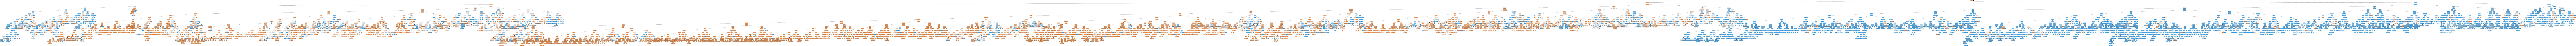

In [44]:
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## 5.2.2 GridSearch para Tree Classification

In [45]:
params_grid = { "criterion" : ["gini", "entropy"],
                "min_samples_leaf": [5,10,15,20,None], 
                "max_depth" : [1,2,3,4,5,6,8,9,10,11,None],
                "min_samples_split": [2, 3, 4,None]}

In [46]:
clftree = tree.DecisionTreeClassifier(random_state=40)
grid_search = GridSearchCV(clftree, params_grid,
                           n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

display(grid_search.best_score_)


In [ ]:
#confusion_matrix(y_test, cv_clf.predict(x_test))

In [ ]:
#cv_clf = grid_search.best_estimator_
#accuracy_score(y_test, cv_clf.predict(x_test))

## 5.7 Modelos con parámetros optimizados

In [ ]:
#Naive Bayes
nb=MultinomialNB()
nb.fit(x_train, y_train)
score_nb=nb.score(x_test,y_test)

#KNN (poner en n_neighbors el best_params_ de GridSearch)
knn=KNeighborsClassifier(n_neighbors=18)
knn.fit(x_train,y_train)
score_knn=knn.score(x_test,y_test)

#Logistic regression
scaler = StandardScaler()
x_trainstd = scaler.fit_transform(x_train)
x_teststd = scaler.transform(x_test)
lr = LogisticRegression()
lr.fit(x_trainstd, y_train)
score_lr= lr.score(x_teststd, y_test)

#Tree Classification
cv_clf = grid_search.best_estimator_
cv_clf.fit(x_train, y_train)
score_t = cv_clf.score(x_test, y_test)

#Score
print ("Naive Bayes Acc Score:",score_nb)
print ("KNN Acc Score:",score_knn)
print ("Logistic Regression Score:", score_lr)
print("Tree classification Score:", score_t)

In [ ]:
y_pred_nb = nb.predict(x_test)
y_pred_knn = knn.predict(x_test)
y_pred_lr = lr.predict(x_teststd)
y_pred_t = cv_clf.predict(x_test)

In [ ]:
print("AS NB:\n", accuracy_score(y_test, y_pred_nb))
print("AS KNN:\n", accuracy_score(y_test, y_pred_knn))
print("AS LR:\n", accuracy_score(y_test, y_pred_lr))
print("T LR:\n", accuracy_score(y_test, cv_clf.predict(x_test)))

#### Confusion_matrix Modelos Mejorados

In [ ]:
print("CM NB:\n", confusion_matrix(y_test, y_pred_nb))
print("CM KNN:\n", confusion_matrix(y_test, y_pred_knn))
print("CM LR:\n", confusion_matrix(y_test, y_pred_lr))
print("T LR:\n", confusion_matrix(y_test, cv_clf.predict(x_test)))

#### Recall,Precision and F-1 Score Modelos mejorados


* Recall    =  TP / (TP + FN)
* Precision = TP / (TP + FP) 
* F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [ ]:
print("NB:\n", classification_report(y_test,y_pred_nb))
print("KNN:\n", classification_report(y_test,y_pred_knn))
print("LR:\n", classification_report(y_test,y_pred_lr))
print("T:\n", classification_report(y_test,cv_clf.predict(x_test)))

In [ ]:
print ("F1 Score NB:", f1_score(y_test,y_pred_nb))
print ("F1 Score KNN:", f1_score(y_test,y_pred_knn))
print ("F1 Score LR:", f1_score(y_test,y_pred_lr))
print ("F1 Score T:", f1_score(y_test,cv_clf.predict(x_test)))

#### roc & auc Modelos mejorados

In [ ]:
#NB
probs_nb=nb.predict_proba(x_test)
preds_nb=probs_nb[:,1]
fpr_nb,tpr_nb, threshold_nb =metrics.roc_curve(y_test, y_pred_nb)
roc_auc_nb=metrics.auc(fpr_nb,tpr_nb)

#KNN
probs_knn=knn.predict_proba(x_test)
preds_knn=probs_knn[:,1]
fpr_knn,tpr_knn, threshold_knn =metrics.roc_curve(y_test, y_pred_knn)
roc_auc_knn=metrics.auc(fpr_knn,tpr_knn)

#LR
probs_lr=lr.predict_proba(x_teststd)
preds_lr=probs_lr[:,1]
fpr_lr,tpr_lr, threshold_lr =metrics.roc_curve(y_test, y_pred_lr)
roc_auc_lr=metrics.auc(fpr_lr,tpr_lr)

#T
probs_t=cv_clf.predict_proba(x_test)
preds_t=probs_t[:,1]
fpr_t,tpr_t, threshold_t =metrics.roc_curve(y_test, y_pred_t)
roc_auc_t=metrics.auc(fpr_t,tpr_t)

print ("ROC AUC NB:", roc_auc_nb)
print ("ROC AUC KNN:", roc_auc_knn)
print ("ROC AUC LR:", roc_auc_lr)
print ("ROC AUC T:", roc_auc_t)

In [ ]:
plt.title("ROC")

plt.plot(fpr_nb, tpr_nb, 'g', label="NB" % roc_auc_nb)
plt.plot(fpr_knn, tpr_knn, 'r', label="KNN" % roc_auc_nb)
plt.plot(fpr_lr, tpr_lr, 'b', label="LR" % roc_auc_nb)
plt.plot(fpr_t, tpr_t, 'y', label="T" % roc_auc_nb)

plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Gráfico post optimización Tree Classification

In [ ]:
dot_data = tree.export_graphviz(cv_clf, out_file=None,feature_names= x_train.columns, filled = True)
graph2 = pydotplus.graph_from_dot_data(dot_data)
Image(graph2.create_png())

# KNN marcelo dani

#### ***Optimizando el valor de k***

<font color='red'>cambio temporario de range(10, 31) a range(10, 21) y folds de 5 a 2</font>

In [ ]:
# Definimos la estrategia de validación cruzada
kf = KFold(n_splits=2, shuffle=True, random_state=12)
scores_para_df_standard = []

#for i in range(10, 31):
for i in range(15, 26):
    Model_knn = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(Model_knn, X_train, y_train, cv=kf)
    dict_row_score = {'score_medio':np.mean(cv_scores),
                      'score_std':np.std(cv_scores), 'n_neighbors':i}
    scores_para_df_standard.append(dict_row_score)

In [ ]:
# Creamos el DataFrame a partir de la lista de diccionarios
df_scores_standard = pd.DataFrame(scores_para_df_standard)
df_scores_standard.head()

**Graficando la búsqueda del mejor hiperparámetro**

In [ ]:
# Generamos los límites inferior y superior
df_scores_standard['limite_superior'] = df_scores_standard['score_medio'] + df_scores_standard['score_std']
df_scores_standard['limite_inferior'] = df_scores_standard['score_medio'] - df_scores_standard['score_std']
df_scores_standard.head()

In [ ]:
# Graficamos los resultados
plt.plot(df_scores_standard['n_neighbors'], df_scores_standard['limite_inferior'], color='r')
plt.plot(df_scores_standard['n_neighbors'], df_scores_standard['score_medio'], color='b')
plt.plot(df_scores_standard['n_neighbors'], df_scores_standard['limite_superior'], color='r');

In [ ]:
# Identificamos el score máximo
df_scores_standard.loc[df_scores_standard.score_medio == df_scores_standard.score_medio.max()]

In [ ]:
# Asignamos el valor del k óptimo a una variable
best_k = df_scores_standard.loc[df_scores_standard.score_medio == df_scores_standard.score_medio.max(), 'n_neighbors'].values[0]
print("best k",best_k)

# Elegimos el modelo óptimo de acuerdo a las pruebas de cross validation
Model_knn = KNeighborsClassifier(n_neighbors=best_k)

# Lo ajustamos sobre los datos de entrenamiento
Model_knn.fit(X_train, y_train)

# Evaluamos qué accuracy obtenemos en train
print("accuracy_score en train",accuracy_score(y_train, Model_knn.predict(X_train)).round(4))

In [ ]:
# Lo utilizamos para predecir en test
X_test = scaler.transform(X_test) # ¡Importantísimo estandarizar también los datos de test con las medias y desvíos aprendidos en train!
y_pred = Model_knn.predict(X_test)

# Evaluamos el accuracy del modelo en test
print("accuracy_score en test",accuracy_score(y_test, y_pred).round(2))

<a id="section_confusion"></a>
### Matriz de confusión

In [ ]:
# Obtenemos la matriz de confusión
_print_matriz_confusion(y_test, y_pred,titulo="KNN Matriz Confusion")

<img src="http://acnalert.eastus.cloudapp.azure.com/2/ds/Confusion.jpg" alt="Matriz confusion">

In [ ]:
#  calcular  la exactitud de nuestro modelo...
print("Acuracy score KNN :\n", accuracy_score(y_test, y_pred).round(2))
print("Classification report KNN:\n", classification_report(y_test,y_pred))

In [ ]:
probs=lr.predict_proba(x_test)
preds=probs[:,1]
fpr,tpr, threshold_lr =metrics.roc_curve(y_test, y_pred)
roc_auc_lr=metrics.auc(fpr_lr,tpr_lr)

#graph
plt.title("ROC")

plt.plot(fpr, tpr, 'b', label="KNN" % roc_auc)
plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()